# MultiRoom RL Agent - PPO (Actor-Critic) implementation
Using PPO (Proximal Policy Optimization) RL technique, Train an agent to navigate through he rooms and doors of the MultiRoom environment.

---




<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png" width="400" height="auto">

- MiniGrid is designed to test and benchmark reinforcement learning algorithms, offering a diverse range of tasks with varying levels of complexity.

- MiniGrid environments are built around the concept of a partially observable, grid-based world where an agent operates to achieve predefined objectives.

- Specificly, the **Multiroom** environment is a grid-based environment where the agent must navigate through a series of rooms to reach a goal.

- Official documentation: https://minigrid.farama.org/environments/minigrid/MultiRoomEnv/

# Imports & Prerequisits

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gymnasium
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
!pip install minigrid
!wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4


## Imports

In [ ]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2

In [ ]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

# **MultiRoom Default Environment**

In the MultiRoomEnv environment, two key mechanisms, **done** and **truncated**, are used to signify the end of an episode. These mechanisms are essential for managing the flow of training and providing valuable feedback about the agent's performance.


### `done` & `truncated`
- The done flag is set to True when the agent successfully reaches the goal.
- It indicates the successful termination of the episode, meaning the agent has completed the task.
- Example scenario: The agent navigates through all the rooms and reaches the green goal square in the final room.
- The truncated flag is used to terminate an episode when a predefined condition is met, such as exceeding the maximum number of steps allowed.
- It does not necessarily indicate success or failure, but rather ensures that episodes do not run indefinitely.
- Example scenario: The agent fails to reach the goal within the allowed number of steps, and the episode ends prematurely.
- **Pay Attention!** - Each time the environment is reset, the configuration of the rooms is randomized. This variability should be carefully considered during training, as resetting the environment every time the **max_step** limit is reached can make it challenging for the agent to learn effectively.
- Additionally, note that the **max_step** parameter is defined as the number of rooms multiplied by 20.

### `Action Space`
- Minigrid uses a discrete action space, which means the agent can only take a limited set of actions, placeholder of 0-6 indexes.
- The default MultiRoom action space is defined as follows:
<br>
action_dict = {
    <br>
0 : 'turn_left',
<br>
1 : 'turn_right',
<br>
2 : 'move_forward',
<br>
3 : 'unused',
<br>
4 : 'unused',
<br>
5 : 'toggle_door',
<br>
6 : 'unused'
}

### `Rewards`
- the default reward for the MultiRoom environment is defined as follows:
<br>
‘1 - 0.9 * (step_count / max_steps)’ is given for success, and ‘0’ for failure.
<br>
Using the RewardShaper - we will modify the reward function to provide a more structured reward signal.

### `Wrappers for Observations`:
**ImgObsWrapper**
- The **ImgObsWrapper** converts the observation from its default dictionary format into a single image array.
- By default, observations in MiniGrid are returned as a dictionary containing both image data and other optional keys (e.g., mission strings). This wrapper extracts only the image component for simplicity.

**RGBImgPartialObsWrapper**
- This wrapper provides a **partial view of the environment**, but instead of limiting it to a fixed field of view, it shows the **entire visible content of the current room** from the agent's position to the walls in the direction the agent is facing.
- The observation dynamically updates as the agent moves or turns, allowing it to see the layout of the room but not beyond its walls or through closed doors.
- This introduces the challenge of **partial observability across multiple rooms**, as the agent must explore and navigate to new rooms to gather more information about the environment.

### `Initialize different environments`
there are 3 different environments that can be initialized:
- **MiniGrid-MultiRoom-N2-S4-v0** - 2 small rooms
- **MiniGrid-MultiRoom-N4-S5-v0** - 6 small rooms
- **MiniGrid-MultiRoom-N6-v0** - 6 large rooms
<br>
The number of rooms and starting positions are randomized each time the environment is reset.
<br>
It is recommended to start with the **MiniGrid-MultiRoom-N2-S4-v0** environment, and then move to the other environments as the agent's performance improves.

# Playground env
test observation, wrappers & action space

In [ ]:
def plot_current_observations(env, partial_obs, title="Current Observations"):
    """
    Plots both the full state (using env.render()) and the current partial observation,
    without resetting the environment.

    Parameters:
    - env: the Gymnasium environment.
    - partial_obs: the current partial observation (from env.reset() or env.step()).
    - title: title for the plot.
    """
    full_state = env.render()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(full_state)
    axs[0].set_title("Full State Observation")
    axs[0].axis('off')

    axs[1].imshow(partial_obs)
    axs[1].set_title("Partial Observation")
    axs[1].axis('off')

    plt.suptitle(title)
    plt.show()

In [ ]:
# Example usage:
# Assume env is already created and wrapped.
env_name = "MiniGrid-MultiRoom-N2-S4-v0"
render_mode = "rgb_array"
highlight = True

env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

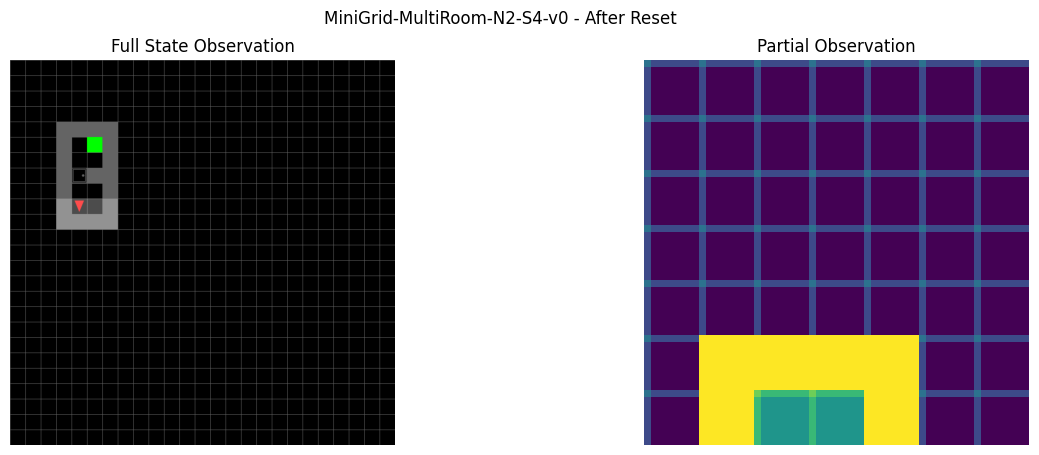

In [ ]:
# Reset the environment once and get the initial observation.
obs, _ = env.reset()
plot_current_observations(env, obs[:, :, 1], title=f"{env_name} - After Reset")

In [ ]:
print(env.unwrapped.agent_pos)
print(env.unwrapped.agent_dir)

(4, 9)
1


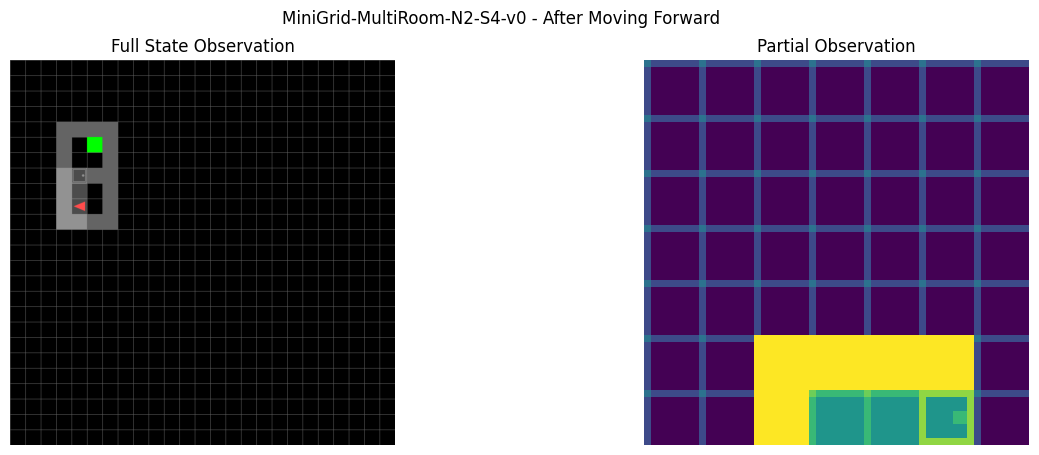

In [ ]:
# Now, take some steps and then plot the current state without resetting.
# For example, take a single 'forward' step.
obs, reward, done, truncated, _ = env.step(1)
plot_current_observations(env, obs[:, :, 1], title=f"{env_name} - After Moving Forward")

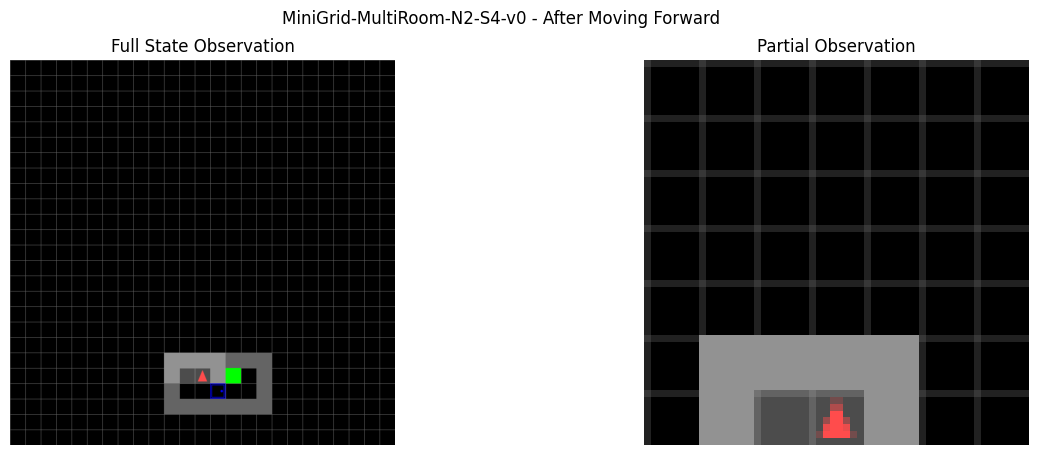

In [ ]:
obs, reward, done, truncated, _ = env.step(2)
plot_current_observations(env, obs, title=f"{env_name} - After Moving Forward")

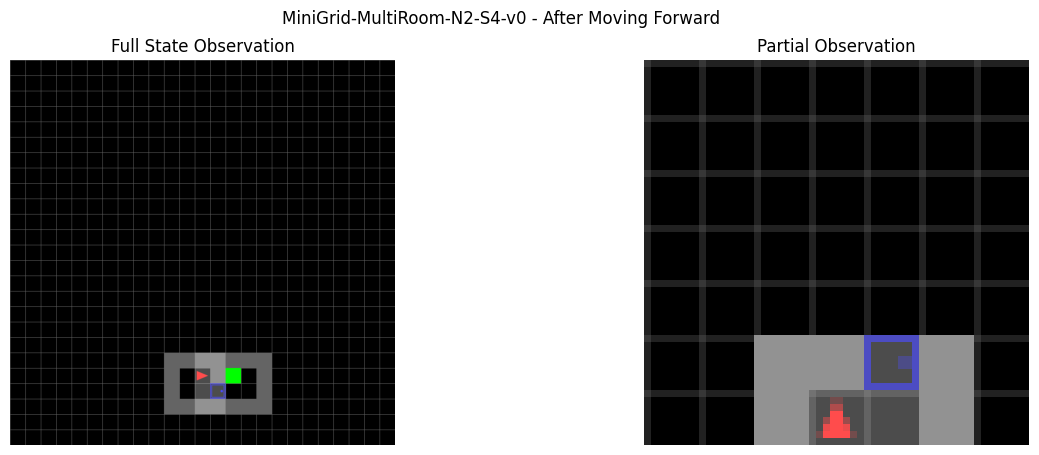

In [ ]:
obs, reward, done, truncated, _ = env.step(1)
plot_current_observations(env, obs, title=f"{env_name} - After Moving Forward")

In [ ]:
# Print the type and shape of the observation.
print("Observation type:", type(obs))
print("Observation shape (RGB):", obs[:, :, 1].shape)
print("Observation shape (green only):", obs[:, :, 1].shape)

# Additionally, inspect the observation space.
print("Observation space:", env.observation_space)

Observation type: <class 'numpy.ndarray'>
Observation shape (RGB): (56, 56)
Observation shape (green only): (56, 56)
Observation space: Box(0, 255, (56, 56, 3), uint8)


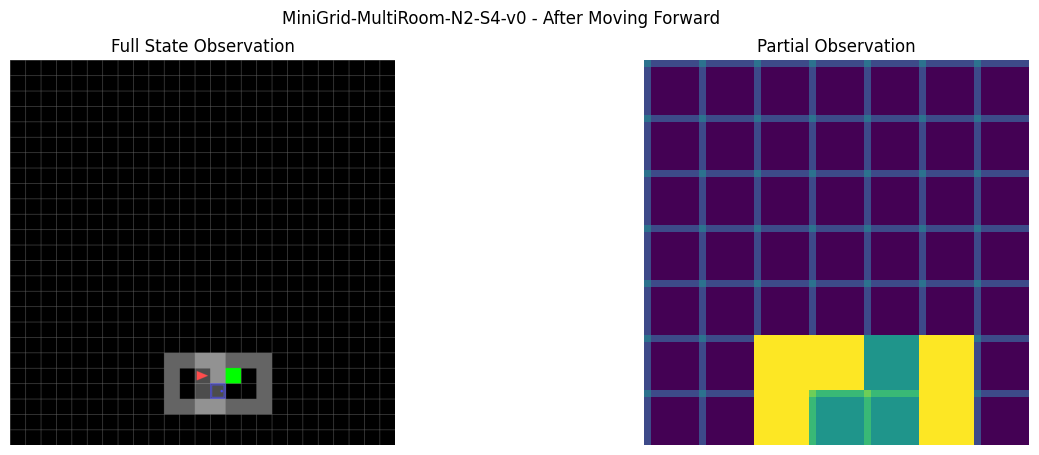

In [ ]:
plot_current_observations(env, obs[:, :, 1], title=f"{env_name} - After Moving Forward")

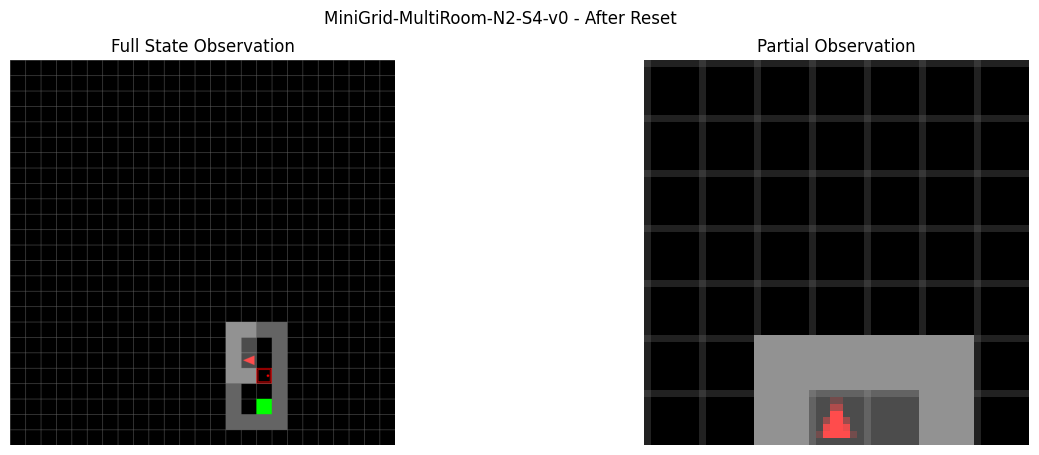

In [ ]:
### Remove me
# Reset the environment once and get the initial observation.
obs, _ = env.reset()
plot_current_observations(env, obs, title=f"{env_name} - After Reset")


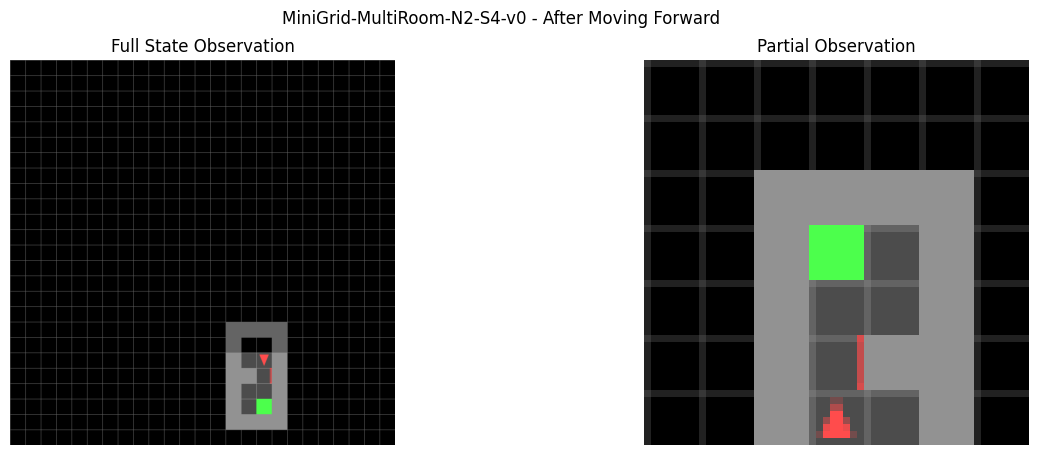

In [ ]:
obs, reward, done, truncated, _ = env.step(1)
obs, reward, done, truncated, _ = env.step(1)
obs, reward, done, truncated, _ = env.step(2)
obs, reward, done, truncated, _ = env.step(1)
obs, reward, done, truncated, _ = env.step(5)

plot_current_observations(env, obs, title=f"{env_name} - After Moving Forward")

In [ ]:
print(env.action_space.n)

7


# Support functions

### Embed video rendering

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Mount to google drive
save files to drive, in case of google colab shutdowns

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Ploting training results
Functions for visualizing training progress by plotting rewards and steps over episodes

In [ ]:
# prompt:  - as a function - plot rewards & steps, and add running average of 25 last episodes

import numpy as np
import matplotlib.pyplot as plt

def plot_rewards_and_steps(rewards, steps):
    # Calculate the running average of the last 200 episodes for rewards
    window_size_rewards = 200
    running_average_rewards = np.convolve(rewards, np.ones(window_size_rewards), 'valid') / window_size_rewards

    # Calculate the running average of the last 200 episodes for steps
    window_size_steps = 200
    running_average_steps = np.convolve(steps, np.ones(window_size_steps), 'valid') / window_size_steps

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot rewards
    axs[0].plot(rewards, label='Episode Reward')
    axs[0].plot(range(window_size_rewards - 1, len(rewards)), running_average_rewards, label=f'Running Average ({window_size_rewards} Episodes)')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].set_title('Episode Rewards with Running Average')
    axs[0].legend()
    axs[0].grid(True)

    # Plot steps
    axs[1].plot(steps, label='Steps per Episode')
    axs[1].plot(range(window_size_steps - 1, len(steps)), running_average_steps, label=f'Running Average ({window_size_steps} Episodes)')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Steps')
    axs[1].set_title('Steps per Episode with Running Average')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Agent

In [ ]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import datetime
import os
import pickle
import h5py
from tqdm import tqdm

## Reward shaper
- The RewardShaper class is used to shape the reward signal for the agent.
- It is used to encourage the agent to explore the environment and open doors.
- It is also used to penalize the agent for repeated actions and for not opening doors.
- It is also used to reward the agent for moving forward after a door has been opened.


In [ ]:
from collections import deque
import numpy as np

DIRECTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]

class RewardShaper:
    def __init__(self):
        self.reset()

    def reset(self):
        """Reset the reward shaper for a new episode."""
        self.last_actions = deque(maxlen=10)
        self.doors = {}  # Track doors by location.
        self.updating_grid = np.zeros((50,50))
        self.direction = 0  # Agent starts facing "Up"
        self.x_pos, self.y_pos = (25,25)  # Start in the middle.
        self.updating_grid[self.y_pos, self.x_pos] = 1

    def step(self, action, previous_state, next_state):
        """Update agent's internal state based on the action."""
        if action == 0:  # turn_left
            self.direction = (self.direction - 1) % 4
        elif action == 1:  # turn_right
            self.direction = (self.direction + 1) % 4
        elif action == 2:  # step_forward
            dx, dy = DIRECTIONS[self.direction]
            self.x_pos += dx
            self.y_pos += dy
            # Clip position to remain within grid bounds.
            self.x_pos = int(np.clip(self.x_pos, 0, 49))
            self.y_pos = int(np.clip(self.y_pos, 0, 49))
        elif action == 3:  # toggle
            pass
        self.updating_grid[self.y_pos, self.x_pos] += 1

    def add_new_door(self, agent_pos):
        if agent_pos not in self.doors:
            self.doors[agent_pos] = {'open': False, 'toggled': False}

    def return_one_cell_infront_position(self):
        dx, dy = DIRECTIONS[self.direction]
        cell_infront_x = self.x_pos + dx
        cell_infront_y = self.y_pos + dy
        return cell_infront_x, cell_infront_y

    def check_state_change(self, previous_state, next_state):
        diff = np.abs(next_state[:, :, 1] - previous_state[:, :, 1])
        threshold = 10
        return np.sum(diff) > threshold

    def reward_shaping(self, action, reward, previous_state, next_state, env, done):
        """Apply reward shaping using the internal grid and door tracking."""
        # Get agent's position and direction
        self.step(action, previous_state, next_state)
        agent_pos = (self.x_pos, self.y_pos)

        # Track visited positions for exploration reward
        if self.updating_grid[self.y_pos, self.x_pos] == 1:
            reward += 0.05

        # (Door candidate check is skipped because heavy image processing is removed.)
        if action == 5:
            if self.check_state_change(previous_state, next_state):
                cell_infront_xy_tuple = self.return_one_cell_infront_position()
                if cell_infront_xy_tuple not in self.doors:
                    self.add_new_door(cell_infront_xy_tuple)
                door = self.doors[cell_infront_xy_tuple]
                if door['open']:
                    reward -= 0.7
                    door['open'] = False
                else:
                    reward += 0.5
                    door['open'] = True
                door['toggled'] = True

            # Penalty for repeated toggling
            if list(self.last_actions)[-3:] == [3] * 3:
                reward -= 0.2  # Discourage repeated toggling

        # Reward for moving forward after door opens
        if action == 2:
            if agent_pos in self.doors and self.doors[agent_pos]['open']:
                reward += 0.2

        # Penalize repeated actions (like spinning in place)
        if len(self.last_actions) >= 3 and len(set(list(self.last_actions)[-3:])) == 1:
            reward -= 0.1  # Repeated action penalty

        if done:
          reward += 5

        # Update the action history
        self.last_actions.append(action)

        return reward

    def extract_door_id(self, state):
        state = state["image"] if isinstance(state, dict) else state
        H, W, C = state.shape
        patch = state[H//2 - 2: H//2 + 2, W//2 - 2: W//2 + 2, :]
        return hash(patch.tobytes())

    def potential(self, state):
        """Return the potential, defined as the number of doors tracked."""
        return len(self.doors)

    def door_interactions_summary(self):
        opened = sum(1 for door in self.doors.values() if door['open'])
        return opened


## Actor-Critic Neural Network Architecture
This network processes the visual input from the environment through convolutional layers and outputs both action probabilities (actor) and state value estimates (critic).
The architecture consists of:
 - Convolutional layers for processing visual input
 - Fully connected layers for high-level feature extraction
 - Separate heads for policy (actor) and value (critic) outputs


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, num_actions, input_channels=3, input_height=56, input_width=56):
        super(ActorCritic, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        dummy = torch.zeros(1, input_channels, input_height, input_width)
        conv_out = self.conv(dummy)
        conv_out_size = conv_out.view(1, -1).size(1)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU()
        )
        self.actor = nn.Linear(256, num_actions)
        self.critic = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value


## PPO Agent
- The PPO class is the main class for the PPO agent.
- It is used to train the PPO model and test the PPO model.
- includes functions to save & load the PPO model.


In [ ]:
class PPOAgent:
    def __init__(self, lr=3e-4, gamma=0.99, clip_epsilon=0.2, update_epochs=8, batch_size=128):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.update_epochs = update_epochs
        self.clip_epsilon = clip_epsilon
        self.batch_size = batch_size
        self.internal_num_actions = 4
        self.network = ActorCritic(self.internal_num_actions, input_channels=3, input_height=56, input_width=56).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.reward_shaper = RewardShaper()
        self.actions_mapper = {0: 0, 1: 1, 2: 2, 3: 5}
        self.rewards = []
        self.steps = []
        self.doors = []
        self.last_episode = 0

    def select_action(self, state):
        if isinstance(state, dict):
            state = state["image"]
        state_tensor = torch.FloatTensor(state / 255.0).permute(2, 0, 1).unsqueeze(0).to(self.device)
        logits, value = self.network(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs)
        internal_action = dist.sample().item()
        actual_action = self.actions_mapper[internal_action]
        internal_action_tensor = torch.tensor(internal_action).to(self.device)
        log_prob = dist.log_prob(internal_action_tensor).item()
        return actual_action, internal_action, log_prob, value.item()

    def compute_returns(self, rewards, dones, last_value):
        returns = []
        R = last_value
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + self.gamma * R * (1 - done)
            returns.insert(0, R)
        return returns

    def update(self, trajectories):
        states_np = np.array([s["image"] if isinstance(s, dict) else s for s in trajectories["states"]])
        states = torch.FloatTensor(states_np / 255.0).to(self.device)
        states = states.permute(0, 3, 1, 2)
        actions = torch.LongTensor(trajectories["actions"]).to(self.device)
        old_log_probs = torch.FloatTensor(trajectories["log_probs"]).to(self.device)
        returns = torch.FloatTensor(trajectories["returns"]).to(self.device)
        values = torch.FloatTensor(trajectories["values"]).to(self.device)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        dataset = torch.utils.data.TensorDataset(states, actions, old_log_probs, returns, advantages)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        epoch_losses = []
        for _ in range(self.update_epochs):
            for batch_states, batch_actions, batch_old_log_probs, batch_returns, batch_advantages in loader:
                logits, batch_values = self.network(batch_states)
                probs = torch.softmax(logits, dim=-1)
                dist = Categorical(probs)
                new_log_probs = dist.log_prob(batch_actions)
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = nn.MSELoss()(batch_values.squeeze(), batch_returns)
                entropy_bonus = -0.01 * dist.entropy().mean()
                loss = actor_loss + 0.5 * critic_loss + entropy_bonus
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        return avg_loss

    def train(self, env, num_episodes):
        for episode in tqdm(range(self.last_episode, num_episodes), initial=self.last_episode, total=num_episodes):
            trajectories = {"states": [], "actions": [], "log_probs": [],
                            "rewards": [], "values": [], "dones": []}
            self.reward_shaper.reset()
            obs, _ = env.reset()
            total_reward = 0
            steps = 0
            while True:
                prev_state = obs.copy() if isinstance(obs, np.ndarray) else obs
                actual_action, internal_action, log_prob, value = self.select_action(obs)
                next_obs, reward, done, truncated, _ = env.step(actual_action)
                shaped_reward = self.reward_shaper.reward_shaping(
                    action=actual_action,
                    reward=reward,
                    previous_state=prev_state,
                    next_state=next_obs,
                    env=env,
                    done=done
                )
                trajectories["states"].append(obs)
                trajectories["actions"].append(internal_action)
                trajectories["log_probs"].append(log_prob)
                trajectories["rewards"].append(shaped_reward)
                trajectories["values"].append(value)
                trajectories["dones"].append(1 if (done or truncated) else 0)
                obs = next_obs
                steps += 1
                total_reward += reward
                if done or truncated:
                    break
            if isinstance(obs, dict):
                obs_img = obs["image"]
            else:
                obs_img = obs
            state_tensor = torch.FloatTensor(obs_img / 255.0).permute(2, 0, 1).unsqueeze(0).to(self.device)
            with torch.no_grad():
                _, last_value = self.network(state_tensor)
            last_value = last_value.item()
            returns = self.compute_returns(trajectories["rewards"], trajectories["dones"], last_value)
            trajectories["returns"] = returns
            _ = self.update(trajectories)

            self.rewards.append(total_reward)
            self.steps.append(steps)
            self.doors.append(self.reward_shaper.door_interactions_summary())
            # Print window summary every 1000 episodes.
            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(self.rewards[-1000:])
                avg_steps = np.mean(self.steps[-1000:])
                avg_doors = np.mean(self.doors[-1000:])
                print(f"\n--- Episodes {episode-998} to {episode+1} Summary ---")
                print(f"Average Reward: {avg_reward:.2f}")
                print(f"Average Steps: {avg_steps:.2f}")
                print(f"Average Doors Opened: {avg_doors:.2f}")
                self.save_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment', episode)

    def save_checkpoint(self, dir, episode):
        timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
        model_filename = f'ppo_model_{timestamp}.pkl'
        model_full_path = os.path.join(dir, model_filename)
        h5_file_name = f'ppo_checkpoint_{timestamp}.h5'
        h5_full_path = os.path.join(dir, h5_file_name)
        os.makedirs(dir, exist_ok=True)
        with open(model_full_path, "wb") as f:
            pickle.dump(self.network.state_dict(), f)
        with h5py.File(h5_full_path, 'a') as f:
            f.create_dataset('rewards', data=np.array(self.rewards))
            f.create_dataset('steps', data=np.array(self.steps))
            f.create_dataset('doors_opened', data=np.array(self.doors))
            f.attrs['last_episode'] = episode
            f.attrs['model_path'] = model_full_path
        print(f"Checkpoint saved: {h5_full_path} and {model_filename}")
        return h5_full_path

    def load_checkpoint(self, h5file_path):
        with h5py.File(h5file_path, 'r') as f:
            self.rewards = f['rewards'][:].tolist()
            self.steps = f['steps'][:].tolist()
            self.doors = f['doors_opened'][:].tolist()
            self.last_episode = f.attrs['last_episode']
            model_path = f.attrs['model_path']
            print(f"Checkpoint loaded from {h5file_path}")
        with open(model_path, "rb") as f:
            self.network.load_state_dict(pickle.load(f))
        print(f"Model loaded from {model_path}")

    def save_model(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.network.state_dict(), f)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        with open(filename, "rb") as f:
            self.network.load_state_dict(pickle.load(f))
        print(f"Model loaded from {filename}")

    def test_model(self, test_num_episodes=10, action_verbose=False, video_name_suffix=''):
        self.network.eval()
        overall_rewards = []
        video_filename = f'test_video{video_name_suffix}.mp4'
        for ep in range(test_num_episodes):
          with imageio.get_writer(video_filename, fps=16) as video:
              state, _ = env.reset()
              total_reward = 0
              steps = 0
              while True:
                  actual_action, internal_action, log_prob, value = self.select_action(state)
                  state, reward, done, truncated, _ = env.step(actual_action)
                  total_reward += reward
                  steps += 1
                  video.append_data(env.render())
                  if done or truncated:
                      break
              overall_rewards.append(total_reward)
              print(f"Test Episode {ep+1}/{test_num_episodes}: Reward: {total_reward}, Steps: {steps}")
        print(f"Average Test Reward: {np.mean(overall_rewards):.2f}")

# Training

## 2 small rooms 

In [ ]:
# Train 2 rooms (MiniGrid-MultiRoom-N2-S4-v0)
import datetime, os, pickle, h5py
env_name = "MiniGrid-MultiRoom-N2-S4-v0"
env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

num_actions = 4  # Internal action space size.
agent = PPOAgent(lr=3e-4, gamma=0.99, clip_epsilon=0.2, update_epochs=8, batch_size=128)

# Train for 10,000 episodes.
agent.train(env, num_episodes=60000)

  2%|▏         | 1001/60000 [02:40<2:42:05,  6.07it/s]

--- Episodes 1 to 1000 Summary ---
Average Reward: 0.06
Average Steps: 37.95
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_220139.h5 and ppo_model_11032025_220139.pkl


  3%|▎         | 2000/60000 [05:18<2:40:42,  6.02it/s]

--- Episodes 1001 to 2000 Summary ---
Average Reward: 0.06
Average Steps: 37.76
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_220417.h5 and ppo_model_11032025_220417.pkl


  5%|▌         | 3000/60000 [07:55<2:38:23,  6.00it/s]

--- Episodes 2001 to 3000 Summary ---
Average Reward: 0.06
Average Steps: 37.87
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_220654.h5 and ppo_model_11032025_220654.pkl


  7%|▋         | 4000/60000 [10:36<2:38:46,  5.88it/s]

--- Episodes 3001 to 4000 Summary ---
Average Reward: 0.05
Average Steps: 38.36
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_220935.h5 and ppo_model_11032025_220935.pkl


  8%|▊         | 5000/60000 [13:15<2:54:01,  5.27it/s]

--- Episodes 4001 to 5000 Summary ---
Average Reward: 0.05
Average Steps: 38.37
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_221214.h5 and ppo_model_11032025_221214.pkl


 10%|█         | 6000/60000 [15:54<3:13:00,  4.66it/s]

--- Episodes 5001 to 6000 Summary ---
Average Reward: 0.06
Average Steps: 38.03
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_221453.h5 and ppo_model_11032025_221453.pkl


 12%|█▏        | 7001/60000 [18:34<2:18:32,  6.38it/s]

--- Episodes 6001 to 7000 Summary ---
Average Reward: 0.04
Average Steps: 38.50
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_221733.h5 and ppo_model_11032025_221733.pkl


 13%|█▎        | 8000/60000 [21:08<2:52:18,  5.03it/s]

--- Episodes 7001 to 8000 Summary ---
Average Reward: 0.09
Average Steps: 36.96
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222007.h5 and ppo_model_11032025_222007.pkl


 15%|█▌        | 9001/60000 [23:24<1:39:38,  8.53it/s]

--- Episodes 8001 to 9000 Summary ---
Average Reward: 0.23
Average Steps: 31.58
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222223.h5 and ppo_model_11032025_222223.pkl


 17%|█▋        | 10001/60000 [25:06<1:15:49, 10.99it/s]

--- Episodes 9001 to 10000 Summary ---
Average Reward: 0.52
Average Steps: 20.35
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222405.h5 and ppo_model_11032025_222405.pkl


 18%|█▊        | 11002/60000 [26:40<1:10:34, 11.57it/s]

--- Episodes 10001 to 11000 Summary ---
Average Reward: 0.57
Average Steps: 17.92
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222539.h5 and ppo_model_11032025_222539.pkl


 20%|██        | 12002/60000 [28:10<1:01:53, 12.93it/s]

--- Episodes 11001 to 12000 Summary ---
Average Reward: 0.61
Average Steps: 16.40
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222708.h5 and ppo_model_11032025_222708.pkl


 22%|██▏       | 13002/60000 [29:27<56:49, 13.78it/s]  

--- Episodes 12001 to 13000 Summary ---
Average Reward: 0.71
Average Steps: 12.43
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222826.h5 and ppo_model_11032025_222826.pkl


 23%|██▎       | 14001/60000 [30:34<53:08, 14.43it/s]

--- Episodes 13001 to 14000 Summary ---
Average Reward: 0.80
Average Steps: 8.65
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_222933.h5 and ppo_model_11032025_222933.pkl


 25%|██▌       | 15000/60000 [32:32<2:07:11,  5.90it/s]

--- Episodes 14001 to 15000 Summary ---
Average Reward: 0.41
Average Steps: 24.18
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_223131.h5 and ppo_model_11032025_223131.pkl


 27%|██▋       | 16001/60000 [34:01<1:36:53,  7.57it/s]

--- Episodes 15001 to 16000 Summary ---
Average Reward: 0.64
Average Steps: 15.18
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_223300.h5 and ppo_model_11032025_223300.pkl


 28%|██▊       | 17002/60000 [35:10<48:24, 14.81it/s]

--- Episodes 16001 to 17000 Summary ---
Average Reward: 0.79
Average Steps: 9.19
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_223409.h5 and ppo_model_11032025_223409.pkl


 30%|███       | 18000/60000 [37:35<2:01:48,  5.75it/s]

--- Episodes 17001 to 18000 Summary ---
Average Reward: 0.18
Average Steps: 33.19
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_223634.h5 and ppo_model_11032025_223634.pkl


 32%|███▏      | 19000/60000 [39:41<2:30:01,  4.55it/s]

--- Episodes 18001 to 19000 Summary ---
Average Reward: 0.33
Average Steps: 27.28
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_223840.h5 and ppo_model_11032025_223840.pkl


 33%|███▎      | 20001/60000 [41:13<51:26, 12.96it/s]

--- Episodes 19001 to 20000 Summary ---
Average Reward: 0.61
Average Steps: 16.32
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_224012.h5 and ppo_model_11032025_224012.pkl


 35%|███▌      | 21001/60000 [42:19<57:22, 11.33it/s]

--- Episodes 20001 to 21000 Summary ---
Average Reward: 0.81
Average Steps: 8.57
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_224118.h5 and ppo_model_11032025_224118.pkl


 37%|███▋      | 22000/60000 [43:44<1:33:24,  6.78it/s]

--- Episodes 21001 to 22000 Summary ---
Average Reward: 0.66
Average Steps: 14.62
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_224243.h5 and ppo_model_11032025_224243.pkl


 38%|███▊      | 23002/60000 [45:43<1:05:27,  9.42it/s]

--- Episodes 22001 to 23000 Summary ---
Average Reward: 0.38
Average Steps: 25.48
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_224442.h5 and ppo_model_11032025_224442.pkl


 40%|████      | 24000/60000 [48:19<1:43:20,  5.81it/s]

--- Episodes 23001 to 24000 Summary ---
Average Reward: 0.10
Average Steps: 36.26
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_224718.h5 and ppo_model_11032025_224718.pkl


 42%|████▏     | 25000/60000 [51:05<2:09:34,  4.50it/s]

--- Episodes 24001 to 25000 Summary ---
Average Reward: 0.00
Average Steps: 40.00
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_225004.h5 and ppo_model_11032025_225004.pkl


 43%|████▎     | 26000/60000 [53:32<1:37:02,  5.84it/s]

--- Episodes 25001 to 26000 Summary ---
Average Reward: 0.15
Average Steps: 34.18
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_225231.h5 and ppo_model_11032025_225231.pkl


 45%|████▌     | 27001/60000 [55:59<1:29:04,  6.17it/s]

--- Episodes 26001 to 27000 Summary ---
Average Reward: 0.15
Average Steps: 34.23
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_225458.h5 and ppo_model_11032025_225458.pkl


 47%|████▋     | 28000/60000 [58:35<1:28:31,  6.02it/s]

--- Episodes 27001 to 28000 Summary ---
Average Reward: 0.07
Average Steps: 37.25
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_225734.h5 and ppo_model_11032025_225734.pkl


 48%|████▊     | 29000/60000 [1:01:19<1:14:18,  6.95it/s]

--- Episodes 28001 to 29000 Summary ---
Average Reward: 0.01
Average Steps: 39.57
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_230018.h5 and ppo_model_11032025_230018.pkl


 50%|█████     | 30001/60000 [1:04:05<1:16:32,  6.53it/s]

--- Episodes 29001 to 30000 Summary ---
Average Reward: 0.02
Average Steps: 39.32
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_230304.h5 and ppo_model_11032025_230304.pkl


 52%|█████▏    | 31000/60000 [1:06:36<1:32:25,  5.23it/s]

--- Episodes 30001 to 31000 Summary ---
Average Reward: 0.12
Average Steps: 35.81
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_230535.h5 and ppo_model_11032025_230535.pkl


 53%|█████▎    | 32000/60000 [1:08:58<1:35:15,  4.90it/s]

--- Episodes 31001 to 32000 Summary ---
Average Reward: 0.18
Average Steps: 33.46
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_230757.h5 and ppo_model_11032025_230757.pkl


 55%|█████▌    | 33000/60000 [1:11:43<1:18:34,  5.73it/s]

--- Episodes 32001 to 33000 Summary ---
Average Reward: 0.00
Average Steps: 40.00
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_231042.h5 and ppo_model_11032025_231042.pkl


 57%|█████▋    | 34000/60000 [1:14:10<1:13:39,  5.88it/s]

--- Episodes 33001 to 34000 Summary ---
Average Reward: 0.15
Average Steps: 34.58
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_231309.h5 and ppo_model_11032025_231309.pkl


 58%|█████▊    | 35000/60000 [1:16:55<1:10:08,  5.94it/s]

--- Episodes 34001 to 35000 Summary ---
Average Reward: 0.00
Average Steps: 40.00
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_231554.h5 and ppo_model_11032025_231554.pkl


 60%|██████    | 36000/60000 [1:19:25<49:00,  8.16it/s]

--- Episodes 35001 to 36000 Summary ---
Average Reward: 0.12
Average Steps: 35.79
Average Doors Opened: 0.00
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_231824.h5 and ppo_model_11032025_231824.pkl


 61%|██████    | 36431/60000 [1:20:09<29:59, 13.10it/s]

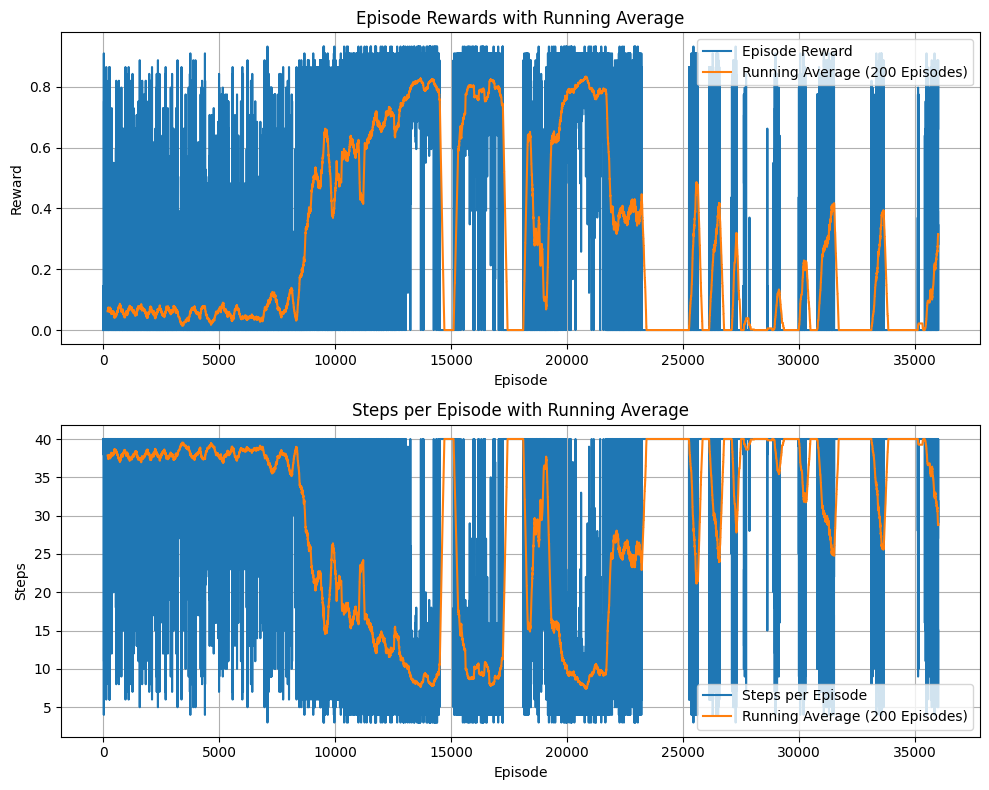

In [ ]:
plot_rewards_and_steps(agent.rewards, agent.steps)

finnaly decided to continue to the 6 small rooms using the best checkpoint we got so far at episode 20K

## 6 small rooms 

In [ ]:
env_name = "MiniGrid-MultiRoom-N4-S5-v0"
env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
env.unwrapped.max_steps = 90
agent = PPOAgent(lr=3e-4, gamma=0.99, clip_epsilon=0.2, update_epochs=8, batch_size=128)

In [ ]:
# Train for 100,000 episodes. 
agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_224118.pkl')
agent.train(env, num_episodes=100000)

Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_224118.pkl


  1%|          | 1000/100000 [04:02<9:12:03,  2.99it/s]


--- Episodes 1 to 1000 Summary ---
Average Reward: 0.28
Average Steps: 59.53
Average Doors Opened: 3.74
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_191637.h5 and ppo_model_12032025_191637.pkl


  2%|▏         | 2000/100000 [08:41<8:54:19,  3.06it/s]


--- Episodes 1001 to 2000 Summary ---
Average Reward: 0.12
Average Steps: 71.41
Average Doors Opened: 2.62
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_192116.h5 and ppo_model_12032025_192116.pkl


  3%|▎         | 3000/100000 [13:31<9:21:17,  2.88it/s]


--- Episodes 2001 to 3000 Summary ---
Average Reward: 0.07
Average Steps: 75.33
Average Doors Opened: 3.94
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_192606.h5 and ppo_model_12032025_192606.pkl


  4%|▍         | 4000/100000 [18:32<8:09:49,  3.27it/s]


--- Episodes 3001 to 4000 Summary ---
Average Reward: 0.04
Average Steps: 77.64
Average Doors Opened: 4.04
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_193107.h5 and ppo_model_12032025_193107.pkl


  5%|▌         | 5000/100000 [23:25<8:13:26,  3.21it/s]


--- Episodes 4001 to 5000 Summary ---
Average Reward: 0.06
Average Steps: 76.14
Average Doors Opened: 4.65
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_193600.h5 and ppo_model_12032025_193600.pkl


  6%|▌         | 6000/100000 [28:26<8:01:47,  3.25it/s]


--- Episodes 5001 to 6000 Summary ---
Average Reward: 0.03
Average Steps: 78.05
Average Doors Opened: 4.57
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_194101.h5 and ppo_model_12032025_194101.pkl


  7%|▋         | 7000/100000 [33:31<8:03:28,  3.21it/s]


--- Episodes 6001 to 7000 Summary ---
Average Reward: 0.00
Average Steps: 79.93
Average Doors Opened: 4.60
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_194606.h5 and ppo_model_12032025_194606.pkl


  8%|▊         | 8000/100000 [38:37<7:57:29,  3.21it/s]


--- Episodes 7001 to 8000 Summary ---
Average Reward: 0.00
Average Steps: 79.91
Average Doors Opened: 4.39
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_195112.h5 and ppo_model_12032025_195112.pkl


  9%|▉         | 9000/100000 [43:46<9:18:22,  2.72it/s]


--- Episodes 8001 to 9000 Summary ---
Average Reward: 0.00
Average Steps: 79.92
Average Doors Opened: 4.73
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_195621.h5 and ppo_model_12032025_195621.pkl


 10%|█         | 10000/100000 [48:53<9:33:27,  2.62it/s]


--- Episodes 9001 to 10000 Summary ---
Average Reward: 0.01
Average Steps: 79.60
Average Doors Opened: 4.78
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_200128.h5 and ppo_model_12032025_200128.pkl


 11%|█         | 11000/100000 [53:54<7:26:13,  3.32it/s]


--- Episodes 10001 to 11000 Summary ---
Average Reward: 0.02
Average Steps: 78.46
Average Doors Opened: 4.85
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_200629.h5 and ppo_model_12032025_200629.pkl


 12%|█▏        | 12000/100000 [58:59<7:25:32,  3.29it/s]


--- Episodes 11001 to 12000 Summary ---
Average Reward: 0.01
Average Steps: 79.23
Average Doors Opened: 3.95
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_201134.h5 and ppo_model_12032025_201134.pkl


 13%|█▎        | 13000/100000 [1:03:58<7:11:03,  3.36it/s]


--- Episodes 12001 to 13000 Summary ---
Average Reward: 0.02
Average Steps: 78.59
Average Doors Opened: 4.69
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_201633.h5 and ppo_model_12032025_201633.pkl


 14%|█▍        | 14000/100000 [1:08:55<8:07:33,  2.94it/s]


--- Episodes 13001 to 14000 Summary ---
Average Reward: 0.02
Average Steps: 78.56
Average Doors Opened: 4.89
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_202130.h5 and ppo_model_12032025_202130.pkl


 15%|█▌        | 15000/100000 [1:13:47<9:21:22,  2.52it/s]


--- Episodes 14001 to 15000 Summary ---
Average Reward: 0.05
Average Steps: 76.58
Average Doors Opened: 4.88
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_202622.h5 and ppo_model_12032025_202622.pkl


 16%|█▌        | 16000/100000 [1:18:47<7:01:43,  3.32it/s]


--- Episodes 15001 to 16000 Summary ---
Average Reward: 0.02
Average Steps: 78.57
Average Doors Opened: 4.72
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_203122.h5 and ppo_model_12032025_203122.pkl


 17%|█▋        | 17000/100000 [1:24:03<7:35:05,  3.04it/s]


--- Episodes 16001 to 17000 Summary ---
Average Reward: 0.00
Average Steps: 80.00
Average Doors Opened: 4.58
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_203638.h5 and ppo_model_12032025_203638.pkl


 18%|█▊        | 18000/100000 [1:29:19<7:16:11,  3.13it/s]


--- Episodes 17001 to 18000 Summary ---
Average Reward: 0.01
Average Steps: 79.61
Average Doors Opened: 4.70
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_204154.h5 and ppo_model_12032025_204154.pkl


 19%|█▉        | 19000/100000 [1:34:36<6:55:05,  3.25it/s]


--- Episodes 18001 to 19000 Summary ---
Average Reward: 0.00
Average Steps: 79.81
Average Doors Opened: 4.79
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_204711.h5 and ppo_model_12032025_204711.pkl


 19%|█▉        | 19069/100000 [1:34:58<6:43:06,  3.35it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-03134ea35432>", line 3, in <cell line: 0>
    agent.train(env, num_episodes=100000)
  File "<ipython-input-20-587530bebdd8>", line 285, in train
    actual_action, internal_action, log_prob, value = self.select_action(obs)
                                                      ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-20-587530bebdd8>", line 227, in select_action
    dist = Categorical(probs)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/distributions/categorical.py", line 72, in __init__
    super().__init__(batch_shape, validate_args=validate_args)
  File "/usr/local/lib/python3.11/dist-packages/torch/distributions/distribution.py", line 69, in __init__
    valid = constraint.check(value)
            ^^^^^^^^^^^^^^^^^^^^^^^
 

TypeError: object of type 'NoneType' has no len()

In [ ]:
agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_204711.h5')
agent.train(env, num_episodes=100000)

Checkpoint loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_204711.h5
Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_12032025_204711.pkl


 19%|█▉        | 19000/100000 [00:00<9:10:14,  2.45it/s]


--- Episodes 18001 to 19000 Summary ---
Average Reward: 0.00
Average Steps: 79.81
Average Doors Opened: 4.79
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_205602.h5 and ppo_model_12032025_205602.pkl


 20%|██        | 20000/100000 [04:58<6:53:00,  3.23it/s]


--- Episodes 19001 to 20000 Summary ---
Average Reward: 0.09
Average Steps: 73.73
Average Doors Opened: 4.75
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_210100.h5 and ppo_model_12032025_210100.pkl


 21%|██        | 21000/100000 [10:05<6:50:30,  3.21it/s]


--- Episodes 20001 to 21000 Summary ---
Average Reward: 0.05
Average Steps: 76.58
Average Doors Opened: 4.64
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_210607.h5 and ppo_model_12032025_210607.pkl


 22%|██▏       | 22000/100000 [15:11<6:47:20,  3.19it/s]


--- Episodes 21001 to 22000 Summary ---
Average Reward: 0.05
Average Steps: 76.78
Average Doors Opened: 4.83
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_211113.h5 and ppo_model_12032025_211113.pkl


 23%|██▎       | 23000/100000 [20:16<7:06:29,  3.01it/s]


--- Episodes 22001 to 23000 Summary ---
Average Reward: 0.06
Average Steps: 75.99
Average Doors Opened: 4.81
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_211618.h5 and ppo_model_12032025_211618.pkl


 24%|██▍       | 24000/100000 [25:19<4:44:45,  4.45it/s]


--- Episodes 23001 to 24000 Summary ---
Average Reward: 0.07
Average Steps: 75.14
Average Doors Opened: 4.66
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_212121.h5 and ppo_model_12032025_212121.pkl


 25%|██▌       | 25000/100000 [29:49<7:44:30,  2.69it/s]


--- Episodes 24001 to 25000 Summary ---
Average Reward: 0.20
Average Steps: 66.01
Average Doors Opened: 4.90
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_212551.h5 and ppo_model_12032025_212551.pkl


 26%|██▌       | 26000/100000 [35:03<6:31:21,  3.15it/s]


--- Episodes 25001 to 26000 Summary ---
Average Reward: 0.02
Average Steps: 78.47
Average Doors Opened: 4.66
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_213105.h5 and ppo_model_12032025_213105.pkl


 27%|██▋       | 27000/100000 [40:21<8:15:06,  2.46it/s]


--- Episodes 26001 to 27000 Summary ---
Average Reward: 0.01
Average Steps: 79.31
Average Doors Opened: 4.72
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_213623.h5 and ppo_model_12032025_213623.pkl


 28%|██▊       | 28000/100000 [45:39<6:17:55,  3.18it/s]


--- Episodes 27001 to 28000 Summary ---
Average Reward: 0.00
Average Steps: 80.00
Average Doors Opened: 4.59
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_214141.h5 and ppo_model_12032025_214141.pkl


 29%|██▉       | 29000/100000 [50:59<6:18:52,  3.12it/s]


--- Episodes 28001 to 29000 Summary ---
Average Reward: 0.00
Average Steps: 79.94
Average Doors Opened: 4.32
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_214700.h5 and ppo_model_12032025_214700.pkl


 30%|███       | 30000/100000 [56:15<6:13:41,  3.12it/s]


--- Episodes 29001 to 30000 Summary ---
Average Reward: 0.00
Average Steps: 80.00
Average Doors Opened: 3.44
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_215216.h5 and ppo_model_12032025_215216.pkl


 31%|███       | 31000/100000 [1:01:30<6:01:06,  3.18it/s]


--- Episodes 30001 to 31000 Summary ---
Average Reward: 0.00
Average Steps: 79.81
Average Doors Opened: 4.58
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_215732.h5 and ppo_model_12032025_215732.pkl


 32%|███▏      | 32000/100000 [1:06:46<6:02:42,  3.12it/s]


--- Episodes 31001 to 32000 Summary ---
Average Reward: 0.01
Average Steps: 79.54
Average Doors Opened: 4.52
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_220247.h5 and ppo_model_12032025_220247.pkl


 33%|███▎      | 33000/100000 [1:12:03<7:29:50,  2.48it/s]


--- Episodes 32001 to 33000 Summary ---
Average Reward: 0.00
Average Steps: 79.97
Average Doors Opened: 4.47
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_220805.h5 and ppo_model_12032025_220805.pkl


 34%|███▍      | 34000/100000 [1:17:19<5:42:43,  3.21it/s]


--- Episodes 33001 to 34000 Summary ---
Average Reward: 0.00
Average Steps: 79.98
Average Doors Opened: 4.42
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_221321.h5 and ppo_model_12032025_221321.pkl


 35%|███▌      | 35000/100000 [1:22:35<5:39:14,  3.19it/s]


--- Episodes 34001 to 35000 Summary ---
Average Reward: 0.00
Average Steps: 80.00
Average Doors Opened: 4.13
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_221837.h5 and ppo_model_12032025_221837.pkl


 36%|███▌      | 36000/100000 [1:27:50<5:28:11,  3.25it/s]


--- Episodes 35001 to 36000 Summary ---
Average Reward: 0.02
Average Steps: 78.83
Average Doors Opened: 4.06
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_222352.h5 and ppo_model_12032025_222352.pkl


 37%|███▋      | 37000/100000 [1:32:52<5:29:05,  3.19it/s]


--- Episodes 36001 to 37000 Summary ---
Average Reward: 0.07
Average Steps: 75.44
Average Doors Opened: 4.41
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_222854.h5 and ppo_model_12032025_222854.pkl


 38%|███▊      | 38000/100000 [1:38:11<5:44:29,  3.00it/s]


--- Episodes 37001 to 38000 Summary ---
Average Reward: 0.00
Average Steps: 79.85
Average Doors Opened: 4.42
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_223413.h5 and ppo_model_12032025_223413.pkl


 39%|███▉      | 39000/100000 [1:43:31<6:58:19,  2.43it/s]


--- Episodes 38001 to 39000 Summary ---
Average Reward: 0.00
Average Steps: 80.00
Average Doors Opened: 3.83
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_223933.h5 and ppo_model_12032025_223933.pkl


 40%|████      | 40000/100000 [1:48:48<5:14:24,  3.18it/s]


--- Episodes 39001 to 40000 Summary ---
Average Reward: 0.00
Average Steps: 79.91
Average Doors Opened: 1.11
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_224450.h5 and ppo_model_12032025_224450.pkl


 41%|████      | 41000/100000 [1:54:05<5:16:13,  3.11it/s]


--- Episodes 40001 to 41000 Summary ---
Average Reward: 0.00
Average Steps: 80.00
Average Doors Opened: 0.10
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_225006.h5 and ppo_model_12032025_225006.pkl


 42%|████▏     | 42000/100000 [1:59:21<6:08:07,  2.63it/s]


--- Episodes 41001 to 42000 Summary ---
Average Reward: 0.00
Average Steps: 79.96
Average Doors Opened: 0.98
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_225523.h5 and ppo_model_12032025_225523.pkl


 43%|████▎     | 43000/100000 [2:04:41<5:04:27,  3.12it/s]


--- Episodes 42001 to 43000 Summary ---
Average Reward: 0.00
Average Steps: 79.97
Average Doors Opened: 3.20
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_230043.h5 and ppo_model_12032025_230043.pkl


 44%|████▎     | 43623/100000 [2:08:01<4:40:11,  3.35it/s]

Checkpoint loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_230043.h5
Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_12032025_230043.pkl


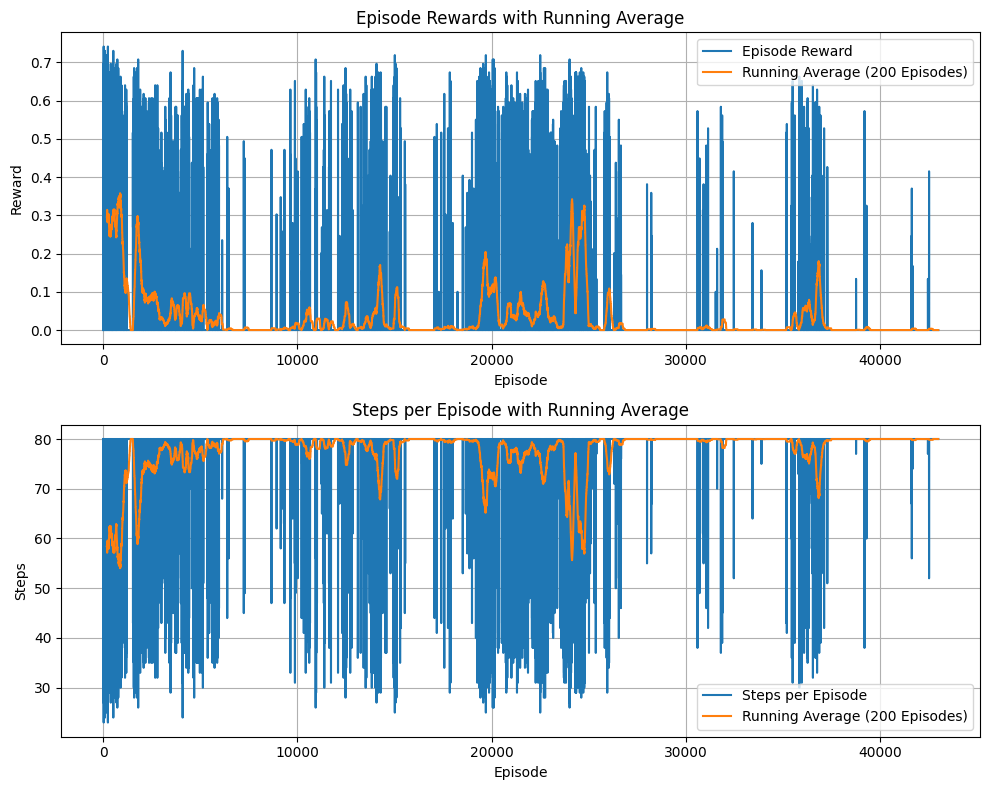

In [ ]:
agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_230043.h5')
plot_rewards_and_steps(agent.rewards, agent.steps)

In [ ]:
agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_212551.h5')
agent.train(env, num_episodes=100000)

Checkpoint loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_212551.h5
Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_12032025_212551.pkl


 25%|██▌       | 25000/100000 [00:00<10:32:01,  1.98it/s]


--- Episodes 24001 to 25000 Summary ---
Average Reward: 0.20
Average Steps: 66.10
Average Doors Opened: 4.90
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_081752.h5 and ppo_model_13032025_081752.pkl


 26%|██▌       | 26000/100000 [06:25<8:32:31,  2.41it/s]


--- Episodes 25001 to 26000 Summary ---
Average Reward: 0.10
Average Steps: 109.62
Average Doors Opened: 4.58
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_082416.h5 and ppo_model_13032025_082416.pkl


 27%|██▋       | 27000/100000 [12:54<5:37:49,  3.60it/s]


--- Episodes 26001 to 27000 Summary ---
Average Reward: 0.08
Average Steps: 111.19
Average Doors Opened: 4.96
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_083046.h5 and ppo_model_13032025_083046.pkl


 28%|██▊       | 28000/100000 [19:27<8:20:35,  2.40it/s]


--- Episodes 27001 to 28000 Summary ---
Average Reward: 0.08
Average Steps: 111.31
Average Doors Opened: 4.42
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_083719.h5 and ppo_model_13032025_083719.pkl


 29%|██▉       | 29000/100000 [26:06<8:19:17,  2.37it/s]


--- Episodes 28001 to 29000 Summary ---
Average Reward: 0.07
Average Steps: 112.61
Average Doors Opened: 4.98
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_084358.h5 and ppo_model_13032025_084358.pkl


 30%|███       | 30000/100000 [32:54<8:10:48,  2.38it/s]


--- Episodes 29001 to 30000 Summary ---
Average Reward: 0.03
Average Steps: 116.74
Average Doors Opened: 4.96
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_085046.h5 and ppo_model_13032025_085046.pkl


 31%|███       | 31000/100000 [39:32<8:25:22,  2.28it/s]


--- Episodes 30001 to 31000 Summary ---
Average Reward: 0.05
Average Steps: 114.12
Average Doors Opened: 4.98
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_085723.h5 and ppo_model_13032025_085723.pkl


 32%|███▏      | 32000/100000 [45:51<7:22:54,  2.56it/s]


--- Episodes 31001 to 32000 Summary ---
Average Reward: 0.12
Average Steps: 106.98
Average Doors Opened: 5.01
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_090343.h5 and ppo_model_13032025_090343.pkl


 33%|███▎      | 33000/100000 [52:16<7:27:07,  2.50it/s]


--- Episodes 32001 to 33000 Summary ---
Average Reward: 0.08
Average Steps: 110.42
Average Doors Opened: 5.02
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_091007.h5 and ppo_model_13032025_091007.pkl


 34%|███▍      | 34000/100000 [58:35<8:01:14,  2.29it/s]


--- Episodes 33001 to 34000 Summary ---
Average Reward: 0.10
Average Steps: 108.88
Average Doors Opened: 5.04
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_091627.h5 and ppo_model_13032025_091627.pkl


 35%|███▌      | 35000/100000 [1:05:04<7:21:19,  2.45it/s]


--- Episodes 34001 to 35000 Summary ---
Average Reward: 0.07
Average Steps: 112.59
Average Doors Opened: 5.08
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_092256.h5 and ppo_model_13032025_092256.pkl


 36%|███▌      | 36000/100000 [1:11:40<5:58:53,  2.97it/s]


--- Episodes 35001 to 36000 Summary ---
Average Reward: 0.05
Average Steps: 114.87
Average Doors Opened: 5.27
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_092932.h5 and ppo_model_13032025_092932.pkl


 37%|███▋      | 37000/100000 [1:18:13<6:33:36,  2.67it/s]


--- Episodes 36001 to 37000 Summary ---
Average Reward: 0.05
Average Steps: 113.88
Average Doors Opened: 5.23
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_093605.h5 and ppo_model_13032025_093605.pkl


 38%|███▊      | 38000/100000 [1:24:42<5:37:37,  3.06it/s]


--- Episodes 37001 to 38000 Summary ---
Average Reward: 0.07
Average Steps: 111.78
Average Doors Opened: 5.10
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_094233.h5 and ppo_model_13032025_094233.pkl


 39%|███▉      | 39000/100000 [1:31:04<6:53:21,  2.46it/s]


--- Episodes 38001 to 39000 Summary ---
Average Reward: 0.10
Average Steps: 108.83
Average Doors Opened: 5.25
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_094856.h5 and ppo_model_13032025_094856.pkl


 40%|████      | 40000/100000 [1:37:33<5:31:58,  3.01it/s]


--- Episodes 39001 to 40000 Summary ---
Average Reward: 0.08
Average Steps: 110.90
Average Doors Opened: 5.09
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_095525.h5 and ppo_model_13032025_095525.pkl


 41%|████      | 41000/100000 [1:43:57<6:09:15,  2.66it/s]


--- Episodes 40001 to 41000 Summary ---
Average Reward: 0.08
Average Steps: 110.53
Average Doors Opened: 5.21
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_100149.h5 and ppo_model_13032025_100149.pkl


 42%|████▏     | 41713/100000 [1:48:34<6:18:37,  2.57it/s]


KeyboardInterrupt: 

In [ ]:
agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_212551.h5')
agent.train(env, num_episodes=100000)

Checkpoint loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_12032025_212551.h5
Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_12032025_212551.pkl


 25%|██▌       | 25000/100000 [00:00<7:47:18,  2.67it/s]


--- Episodes 24001 to 25000 Summary ---
Average Reward: 0.20
Average Steps: 66.07
Average Doors Opened: 4.90
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_101732.h5 and ppo_model_13032025_101732.pkl


 26%|██▌       | 26000/100000 [05:17<6:45:44,  3.04it/s]


--- Episodes 25001 to 26000 Summary ---
Average Reward: 0.00
Average Steps: 89.92
Average Doors Opened: 1.40
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_102249.h5 and ppo_model_13032025_102249.pkl


 27%|██▋       | 27001/100000 [08:52<2:55:08,  6.95it/s]


--- Episodes 26001 to 27000 Summary ---
Average Reward: 0.39
Average Steps: 57.15
Average Doors Opened: 4.58
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_102623.h5 and ppo_model_13032025_102623.pkl


 28%|██▊       | 28000/100000 [11:38<3:05:12,  6.48it/s]


--- Episodes 27001 to 28000 Summary ---
Average Reward: 0.58
Average Steps: 41.82
Average Doors Opened: 4.91
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_102910.h5 and ppo_model_13032025_102910.pkl


 29%|██▉       | 29001/100000 [14:19<2:47:19,  7.07it/s]


--- Episodes 28001 to 29000 Summary ---
Average Reward: 0.60
Average Steps: 39.86
Average Doors Opened: 4.95
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_103151.h5 and ppo_model_13032025_103151.pkl


 30%|███       | 30000/100000 [16:55<2:56:00,  6.63it/s]


--- Episodes 29001 to 30000 Summary ---
Average Reward: 0.62
Average Steps: 37.99
Average Doors Opened: 4.94
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_103426.h5 and ppo_model_13032025_103426.pkl


 31%|███       | 31000/100000 [19:32<3:37:35,  5.29it/s]


--- Episodes 30001 to 31000 Summary ---
Average Reward: 0.61
Average Steps: 38.79
Average Doors Opened: 4.97
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_103703.h5 and ppo_model_13032025_103703.pkl


 32%|███▏      | 32000/100000 [22:08<3:00:38,  6.27it/s]


--- Episodes 31001 to 32000 Summary ---
Average Reward: 0.61
Average Steps: 38.27
Average Doors Opened: 4.95
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_103939.h5 and ppo_model_13032025_103939.pkl


 33%|███▎      | 33001/100000 [24:43<2:44:05,  6.80it/s]


--- Episodes 32001 to 33000 Summary ---
Average Reward: 0.62
Average Steps: 37.50
Average Doors Opened: 4.97
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_104214.h5 and ppo_model_13032025_104214.pkl


 33%|███▎      | 33065/100000 [24:53<3:26:32,  5.40it/s]


KeyboardInterrupt: 

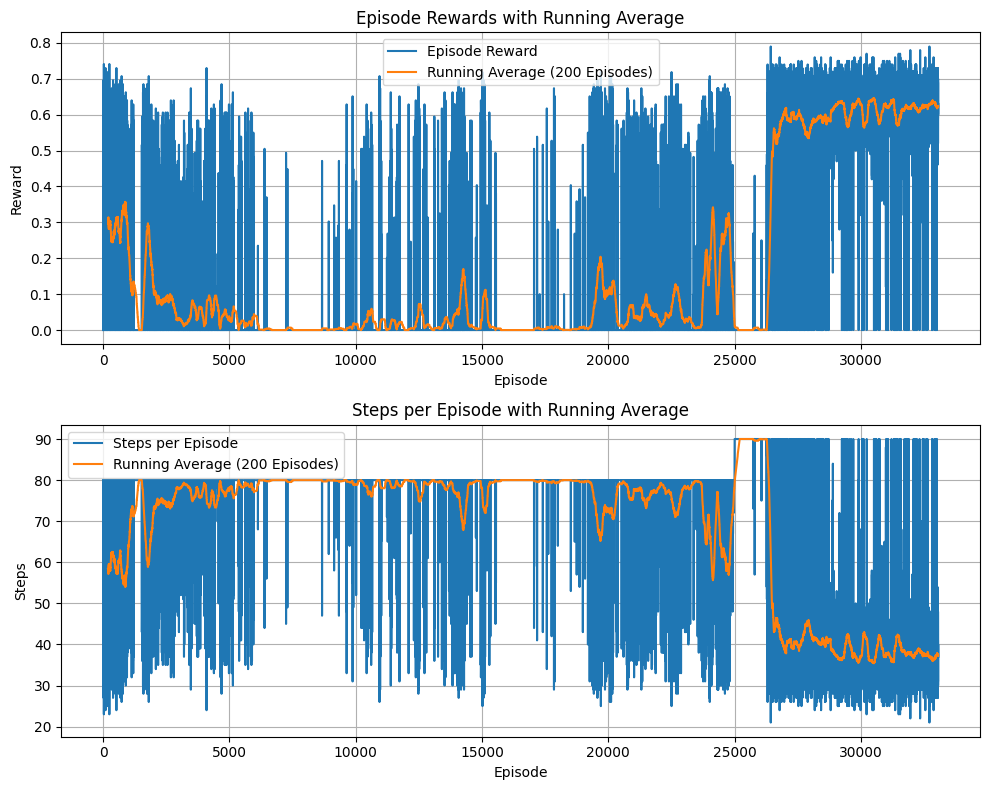

In [ ]:
plot_rewards_and_steps(agent.rewards, agent.steps)

## 6 large rooms

In [ ]:
env_name = "MiniGrid-MultiRoom-N6-v0"
env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
env.unwrapped.max_steps = 100
agent = PPOAgent(lr=3e-4, gamma=0.99, clip_epsilon=0.2, update_epochs=8, batch_size=128)

In [ ]:
# Train for 100,000 episodes. Load model from 6 small rooms
agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_104214.pkl')
agent.train(env, num_episodes=100000)

Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_104214.pkl


  1%|          | 1000/100000 [05:41<9:26:30,  2.91it/s]


--- Episodes 1 to 1000 Summary ---
Average Reward: 0.01
Average Steps: 99.17
Average Doors Opened: 1.11
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_105407.h5 and ppo_model_13032025_105407.pkl


  2%|▏         | 2000/100000 [11:27<9:15:07,  2.94it/s]


--- Episodes 1001 to 2000 Summary ---
Average Reward: 0.00
Average Steps: 99.86
Average Doors Opened: 1.37
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_105952.h5 and ppo_model_13032025_105952.pkl


  3%|▎         | 3000/100000 [17:09<9:03:52,  2.97it/s]


--- Episodes 2001 to 3000 Summary ---
Average Reward: 0.01
Average Steps: 98.86
Average Doors Opened: 1.77
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_110535.h5 and ppo_model_13032025_110535.pkl


  4%|▍         | 4000/100000 [22:33<7:04:27,  3.77it/s]


--- Episodes 3001 to 4000 Summary ---
Average Reward: 0.10
Average Steps: 92.25
Average Doors Opened: 3.23
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_111059.h5 and ppo_model_13032025_111059.pkl


  5%|▌         | 5000/100000 [28:07<8:42:46,  3.03it/s]


--- Episodes 4001 to 5000 Summary ---
Average Reward: 0.05
Average Steps: 96.11
Average Doors Opened: 2.36
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_111632.h5 and ppo_model_13032025_111632.pkl


  6%|▌         | 6000/100000 [33:48<8:50:56,  2.95it/s]


--- Episodes 5001 to 6000 Summary ---
Average Reward: 0.02
Average Steps: 98.77
Average Doors Opened: 2.35
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_112213.h5 and ppo_model_13032025_112213.pkl


  7%|▋         | 7000/100000 [39:04<9:04:43,  2.85it/s]


--- Episodes 6001 to 7000 Summary ---
Average Reward: 0.12
Average Steps: 90.67
Average Doors Opened: 3.38
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_112729.h5 and ppo_model_13032025_112729.pkl


  8%|▊         | 8000/100000 [44:27<9:10:26,  2.79it/s]


--- Episodes 7001 to 8000 Summary ---
Average Reward: 0.10
Average Steps: 92.39
Average Doors Opened: 3.31
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_113252.h5 and ppo_model_13032025_113252.pkl


  9%|▉         | 9000/100000 [50:04<8:42:41,  2.90it/s]


--- Episodes 8001 to 9000 Summary ---
Average Reward: 0.04
Average Steps: 97.03
Average Doors Opened: 2.75
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_113830.h5 and ppo_model_13032025_113830.pkl


 10%|█         | 10000/100000 [55:50<8:38:03,  2.90it/s]


--- Episodes 9001 to 10000 Summary ---
Average Reward: 0.02
Average Steps: 98.31
Average Doors Opened: 2.49
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_114415.h5 and ppo_model_13032025_114415.pkl


 11%|█         | 11000/100000 [1:00:59<5:39:33,  4.37it/s]


--- Episodes 10001 to 11000 Summary ---
Average Reward: 0.15
Average Steps: 87.65
Average Doors Opened: 3.75
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_114924.h5 and ppo_model_13032025_114924.pkl


 12%|█▏        | 12000/100000 [1:06:00<10:33:06,  2.32it/s]


--- Episodes 11001 to 12000 Summary ---
Average Reward: 0.18
Average Steps: 84.81
Average Doors Opened: 3.59
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_115425.h5 and ppo_model_13032025_115425.pkl


 13%|█▎        | 13000/100000 [1:11:38<8:09:50,  2.96it/s]


--- Episodes 12001 to 13000 Summary ---
Average Reward: 0.03
Average Steps: 97.59
Average Doors Opened: 2.67
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_120003.h5 and ppo_model_13032025_120003.pkl


 14%|█▍        | 14000/100000 [1:17:21<10:07:20,  2.36it/s]


--- Episodes 13001 to 14000 Summary ---
Average Reward: 0.01
Average Steps: 99.12
Average Doors Opened: 1.38
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_120546.h5 and ppo_model_13032025_120546.pkl


 15%|█▌        | 15000/100000 [1:22:01<6:17:33,  3.75it/s]


--- Episodes 14001 to 15000 Summary ---
Average Reward: 0.26
Average Steps: 78.18
Average Doors Opened: 4.01
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_121026.h5 and ppo_model_13032025_121026.pkl


 16%|█▌        | 16000/100000 [1:26:21<8:17:58,  2.81it/s]


--- Episodes 15001 to 16000 Summary ---
Average Reward: 0.34
Average Steps: 71.24
Average Doors Opened: 4.54
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_121446.h5 and ppo_model_13032025_121446.pkl


 17%|█▋        | 17000/100000 [1:30:51<5:11:55,  4.43it/s]


--- Episodes 16001 to 17000 Summary ---
Average Reward: 0.31
Average Steps: 74.02
Average Doors Opened: 4.34
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_121916.h5 and ppo_model_13032025_121916.pkl


 18%|█▊        | 18000/100000 [1:35:45<7:57:16,  2.86it/s]


--- Episodes 17001 to 18000 Summary ---
Average Reward: 0.23
Average Steps: 80.09
Average Doors Opened: 3.45
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_122410.h5 and ppo_model_13032025_122410.pkl


 19%|█▉        | 19000/100000 [1:39:47<6:14:13,  3.61it/s]


--- Episodes 18001 to 19000 Summary ---
Average Reward: 0.42
Average Steps: 63.45
Average Doors Opened: 4.91
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_122813.h5 and ppo_model_13032025_122813.pkl


 20%|██        | 20000/100000 [1:43:41<6:27:39,  3.44it/s]


--- Episodes 19001 to 20000 Summary ---
Average Reward: 0.45
Average Steps: 60.90
Average Doors Opened: 4.96
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_123206.h5 and ppo_model_13032025_123206.pkl


 21%|██        | 21000/100000 [1:48:05<7:31:24,  2.92it/s]


--- Episodes 20001 to 21000 Summary ---
Average Reward: 0.33
Average Steps: 71.69
Average Doors Opened: 4.16
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_123630.h5 and ppo_model_13032025_123630.pkl


 22%|██▏       | 22000/100000 [1:53:11<7:25:53,  2.92it/s]


--- Episodes 21001 to 22000 Summary ---
Average Reward: 0.18
Average Steps: 83.93
Average Doors Opened: 2.91
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_124136.h5 and ppo_model_13032025_124136.pkl


 23%|██▎       | 23000/100000 [1:58:49<7:19:54,  2.92it/s]


--- Episodes 22001 to 23000 Summary ---
Average Reward: 0.12
Average Steps: 89.54
Average Doors Opened: 1.80
Checkpoint saved: /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_124714.h5 and ppo_model_13032025_124714.pkl


 24%|██▎       | 23586/100000 [2:02:11<6:46:30,  3.13it/s]

Checkpoint loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_124714.h5
Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_124714.pkl


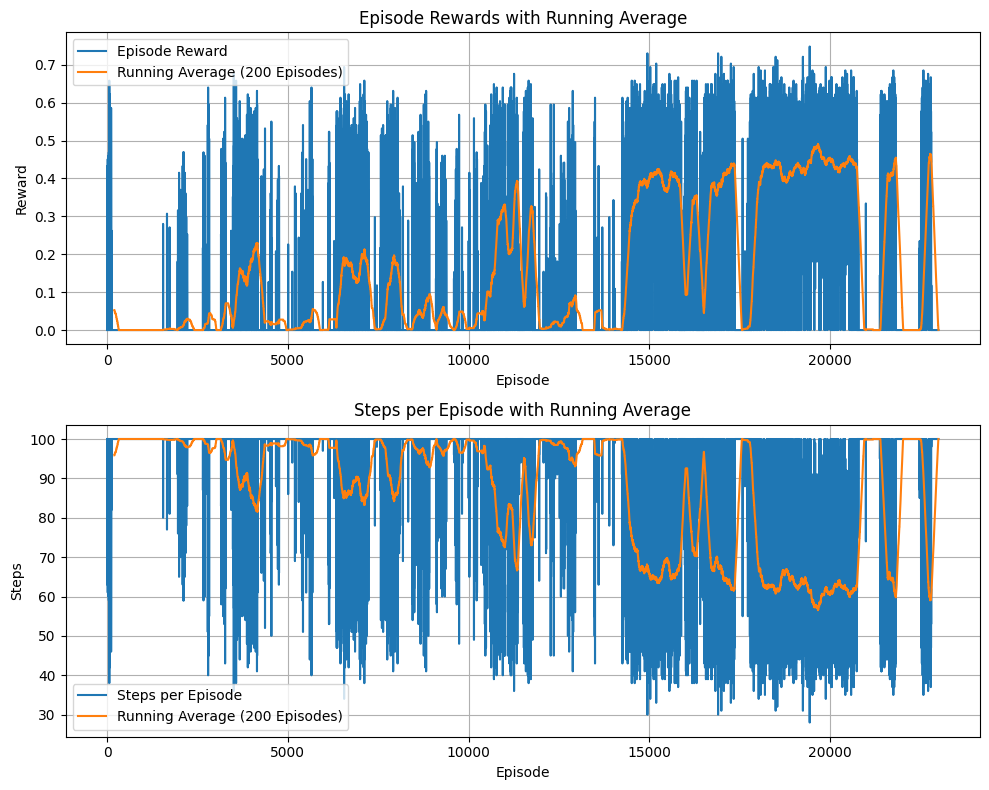

In [ ]:
agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_124714.h5')
plot_rewards_and_steps(agent.rewards, agent.steps)

Checkpoint loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_123206.h5
Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_123206.pkl


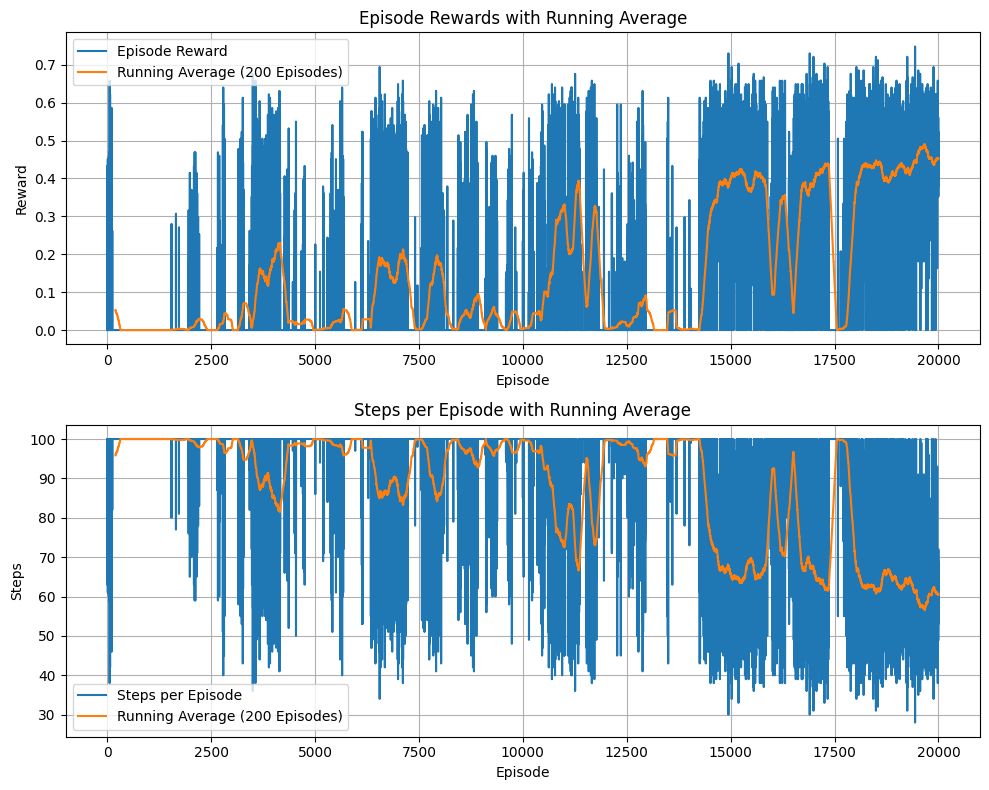

In [ ]:
# plot up to episode 20K
agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_13032025_123206.h5')
plot_rewards_and_steps(agent.rewards, agent.steps)

we will test the checkpoint from episode 20,000

# Tests

## 2 small rooms 

In [ ]:
env_name = "MiniGrid-MultiRoom-N2-S4-v0"
env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

num_actions = 4  # Internal action space size.
agent = PPOAgent(lr=3e-4, gamma=0.99, clip_epsilon=0.2, update_epochs=8, batch_size=128)

In [ ]:
# agent.load_checkpoint('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_checkpoint_11032025_231824.h5')
# agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_231824.pkl') # not good
agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_224118.pkl') # taken from 21K episode

Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_224118.pkl


In [ ]:
agent.test_model(test_num_episodes=10, action_verbose=False, video_name_suffix='_2rooms')
video_filename = 'test_video_2rooms.mp4'
embed_mp4(video_filename)

Test Episode 1/10: Reward: 0.7525, Steps: 11
Test Episode 2/10: Reward: 0.865, Steps: 6
Test Episode 3/10: Reward: 0.8875, Steps: 5
Test Episode 4/10: Reward: 0.82, Steps: 8
Test Episode 5/10: Reward: 0.865, Steps: 6
Test Episode 6/10: Reward: 0.7975, Steps: 9
Test Episode 7/10: Reward: 0.9325, Steps: 3
Test Episode 8/10: Reward: 0.82, Steps: 8
Test Episode 9/10: Reward: 0.7975, Steps: 9
Test Episode 10/10: Reward: 0.7525, Steps: 11
Average Test Reward: 0.83


## 6 small rooms 

In [ ]:
import datetime, os, pickle, h5py
env_name = "MiniGrid-MultiRoom-N4-S5-v0"
env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

agent = PPOAgent(lr=3e-4, gamma=0.99, clip_epsilon=0.2, update_epochs=8, batch_size=128)

In [ ]:
# initiall attempts, not good
agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_224118.pkl') # taken from 21K episode
agent.test_model(test_num_episodes=1, action_verbose=False, video_name_suffix='_6smallrooms')
video_filename = 'test_video_2rooms.mp4'
embed_mp4(video_filename)

Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_11032025_224118.pkl
Test Episode 1/1: Reward: 0.55, Steps: 40
Average Test Reward: 0.55


In [ ]:
agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_074730.pkl')
agent.test_model(test_num_episodes=1, action_verbose=False, video_name_suffix='_6smallrooms')
video_filename = 'test_video_6smallrooms.mp4'
embed_mp4(video_filename)

Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_074730.pkl
Test Episode 1/1: Reward: 0, Steps: 120
Average Test Reward: 0.00


In [ ]:
# final one- best results

agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_104214.pkl')
agent.test_model(test_num_episodes=10, action_verbose=False, video_name_suffix='_6smallrooms')
video_filename = 'test_video_6smallrooms.mp4'
embed_mp4(video_filename)

Test Episode 1/10: Reward: 0.57, Steps: 43
Test Episode 2/10: Reward: 0.6499999999999999, Steps: 35
Test Episode 3/10: Reward: 0.6599999999999999, Steps: 34
Test Episode 4/10: Reward: 0.6799999999999999, Steps: 32
Test Episode 5/10: Reward: 0.6000000000000001, Steps: 40
Test Episode 6/10: Reward: 0.63, Steps: 37
Test Episode 7/10: Reward: 0.36, Steps: 64
Test Episode 8/10: Reward: 0.5900000000000001, Steps: 41
Test Episode 9/10: Reward: 0.67, Steps: 33
Test Episode 10/10: Reward: 0.67, Steps: 33
Average Test Reward: 0.61


## 6 large rooms 

In [ ]:
# final one- best results

agent.load_model('/content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_123206.pkl')
agent.test_model(test_num_episodes=10, action_verbose=False, video_name_suffix='_6largerooms')
video_filename = 'test_video_6largerooms.mp4'
embed_mp4(video_filename)

Model loaded from /content/drive/MyDrive/RL_MultiRoom_Assignment/ppo_model_13032025_123206.pkl
Test Episode 1/10: Reward: 0.5680000000000001, Steps: 48
Test Episode 2/10: Reward: 0.262, Steps: 82
Test Episode 3/10: Reward: 0.532, Steps: 52
Test Episode 4/10: Reward: 0.45999999999999996, Steps: 60
Test Episode 5/10: Reward: 0.577, Steps: 47
Test Episode 6/10: Reward: 0.532, Steps: 52
Test Episode 7/10: Reward: 0.5589999999999999, Steps: 49
Test Episode 8/10: Reward: 0.4149999999999999, Steps: 65
Test Episode 9/10: Reward: 0.55, Steps: 50
Test Episode 10/10: Reward: 0.37, Steps: 70
Average Test Reward: 0.48


# Additional plots

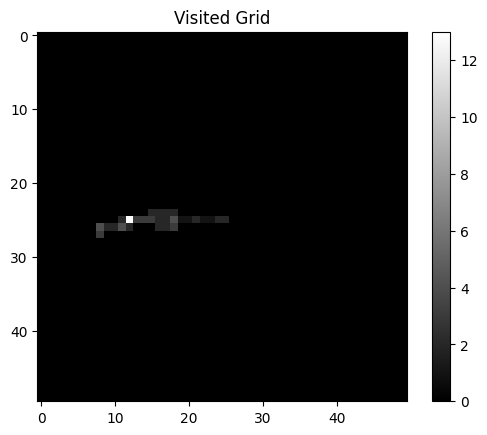

In [ ]:
# we can see in this grid visualization, that the player was stuck in a door (from some itteration)
grid = agent.reward_shaper.updating_grid
plt.imshow(grid, cmap='gray')
plt.title('Visited Grid')
plt.colorbar()
plt.show()

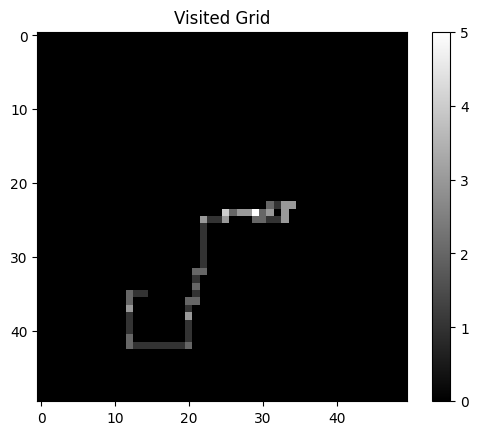

In [ ]:
# we can see the running player across the full path to the finish line

grid = agent.reward_shaper.updating_grid
plt.imshow(grid, cmap='gray')
plt.title('Visited Grid')
plt.colorbar()
plt.show()